# Finding Heavy Traffic Indicators on I-94

This is a project to analyze a dataset about the westbound traffic on the I-94 Interstate Highway. The data for it is available [here](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume).

In particular, we will be looking at time and weather indicators. We'll also look at the influence of holidays.

In [1]:
import pandas as pd

traffic = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')
traffic.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [2]:
traffic.tail()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
48199,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450
48203,None,282.12,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 23:00:00,954


In [3]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


## Analyzing Traffic Volume

The dataset documentation mentions that a station located approximately midway between Minneapolis and Saint Paul recorded the traffic data. Also, the station only records westbound traffic (cars moving from east to west).

This means that the results of our analysis will be about the westbound traffic in the proximity of that station. In other words, we should avoid generalizing our results for the entire I-94 highway.

Let's analyze some of the distributions:

<AxesSubplot:ylabel='Frequency'>

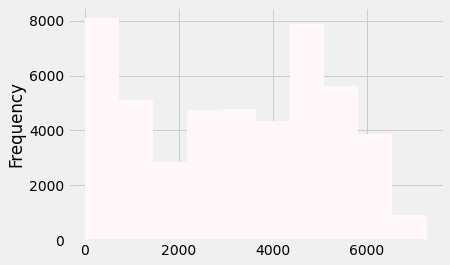

In [4]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.style.use('fivethirtyeight')
traffic['traffic_volume'].plot(kind='hist', colormap='PuBu')

In [5]:
traffic['traffic_volume'].describe()

count    48204.000000
mean      3259.818355
std       1986.860670
min          0.000000
25%       1193.000000
50%       3380.000000
75%       4933.000000
max       7280.000000
Name: traffic_volume, dtype: float64

THere is an average of 3260 cars with a variance of 0 to 7280. From here it seems interesting to compare day vs night.

### Traffic Volume: Day vs. Night

We will divide the dataset into two parts:
- Daytime data: hours from 7 a.m. to 7 p.m. (12 hours)
- Nighttime data: hours from 7 p.m. to 7 a.m. (12 hours)

In [6]:
traffic['date_time'] = pd.to_datetime(traffic['date_time'])

day = traffic.copy()[(traffic['date_time'].dt.hour >= 7) & (traffic['date_time'].dt.hour < 19)]
print(day.shape)

night = traffic.copy()[(traffic['date_time'].dt.hour >= 19) | (traffic['date_time'].dt.hour < 7)]
print(night.shape)

(23877, 9)
(24327, 9)


There are differences between the two in terms of time data, but this is due to lack of recording due to a few hours of missing data.

Text(0.5, 0, 'Traffic Volume')

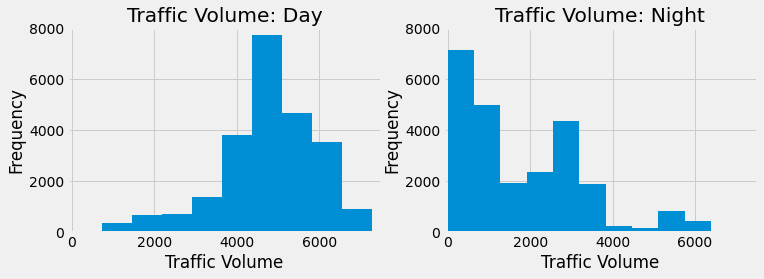

In [7]:
plt.figure(figsize=(11,3.5))

plt.subplot(1, 2, 1)
plt.hist(day['traffic_volume'])
plt.xlim(-100, 7500)
plt.ylim(0, 8000)
plt.title('Traffic Volume: Day')
plt.ylabel('Frequency')
plt.xlabel('Traffic Volume')

plt.subplot(1, 2, 2)
plt.hist(night['traffic_volume'])
plt.xlim(-100, 7500)
plt.ylim(0, 8000)
plt.title('Traffic Volume: Night')
plt.ylabel('Frequency')
plt.xlabel('Traffic Volume')

In [8]:
day['traffic_volume'].describe()

count    23877.000000
mean      4762.047452
std       1174.546482
min          0.000000
25%       4252.000000
50%       4820.000000
75%       5559.000000
max       7280.000000
Name: traffic_volume, dtype: float64

In [9]:
night['traffic_volume'].describe()

count    24327.000000
mean      1785.377441
std       1441.951197
min          0.000000
25%        530.000000
50%       1287.000000
75%       2819.000000
max       6386.000000
Name: traffic_volume, dtype: float64

Day traffic is left skewed and night traffic is right skewed. Looking at the descriptive statitstics we see that the maxes are somewhat in the same range but the averages are significantly different.

## Analyzing Time Indicators of the Day

Previously, we determined that the traffic at night is generally light. Our goal is to find indicators of heavy traffic, so for now we will focus on the daytime data moving forward.

One of the possible indicators of heavy traffic is time. There might be more people on the road in a certain month, on a certain day, or at a certain time of the day. We're going to look at a few line plots showing how the traffic volume changed according to the following parameters:

- Month
- Day of the week
- Time of day

### Month Analysis

<AxesSubplot:xlabel='month', ylabel='Average Frequency'>

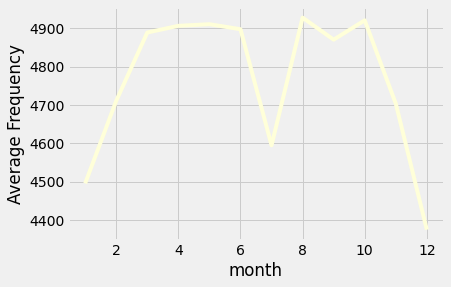

In [10]:
day['month'] = day['date_time'].dt.month
by_month = day.groupby('month').mean()
by_month['traffic_volume'].plot(kind='line', ylabel='Average Frequency', colormap='YlGnBu')

Traffic looks less heavy during the cold months and more intense during warm months except July?

We can looking at July in particular:

<AxesSubplot:xlabel='year', ylabel='Average Frequency'>

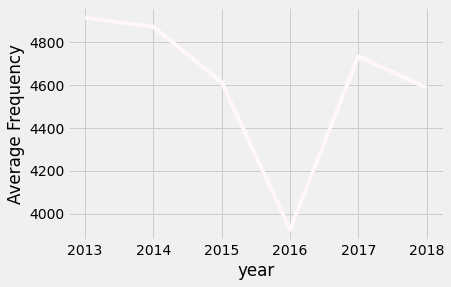

In [11]:
day['year'] = day['date_time'].dt.year
only_july = day[day['month'] == 7]
only_july.groupby('year').mean()['traffic_volume'].plot(kind='line', ylabel='Average Frequency', colormap='PuBuGn')

On a per year basis, we can see there is a dip in 2016 which could be due to some external factor such as road construction or closure.

### Day of Week Analysis

<AxesSubplot:xlabel='dayofweek', ylabel='Average Frequency'>

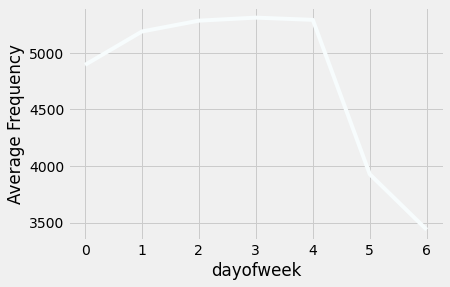

In [12]:
day['dayofweek'] = day['date_time'].dt.dayofweek
by_dayofweek = day.groupby('dayofweek').mean()
by_dayofweek['traffic_volume'].plot(kind='line',ylabel='Average Frequency', colormap='BuGn')

Looking at the traffic per day (Monday = 0 and Sunday = 6), we can see that the weekend traffic drops significantly.

### Hour Analysis

Text(0.5, 1.0, 'Traffic Volume By Hour: Weekend')

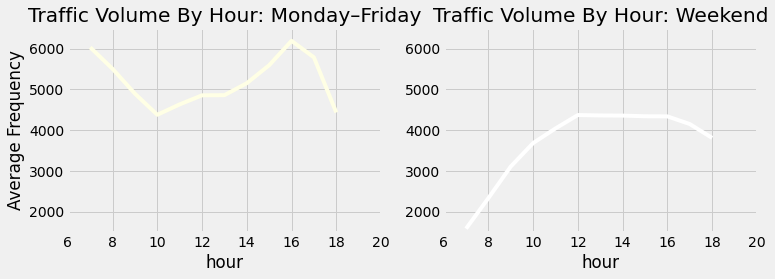

In [13]:
day['hour'] = day['date_time'].dt.hour
bussiness_days = day.copy()[day['dayofweek'] <= 4] # 4 == Friday
weekend = day.copy()[day['dayofweek'] >= 5] # 5 = Saturday
by_hour_business = bussiness_days.groupby('hour').mean()
by_hour_weekend = weekend.groupby('hour').mean()


plt.figure(figsize=(11,3.5))

plt.subplot(1, 2, 1)
by_hour_business['traffic_volume'].plot(kind='line',ylabel='Average Frequency',colormap='YlGn')
plt.xlim(6,20)
plt.ylim(1500,6500)
plt.title('Traffic Volume By Hour: Monday–Friday')

plt.subplot(1, 2, 2)
by_hour_weekend['traffic_volume'].plot(kind='line',colormap='binary')
plt.xlim(6,20)
plt.ylim(1500,6500)
plt.title('Traffic Volume By Hour: Weekend')

When looking at this drop on the weekend, it seems to show that the early morning is much lower than during the weekdays themselves.

Thus we can reach the following conclusions:
- The traffic is usually heavier during warm months (March–October) compared to cold months (November–February).
- The traffic is usually heavier on business days compared to weekends.
- On business days, the rush hours are around 8 (AM) and 16 (5 PM).

## Analyzing Time Indicators of the Night

Let us see if we can repeat the analysis but specifically at night.

### Month Analysis

<AxesSubplot:xlabel='month', ylabel='Average Frequency'>

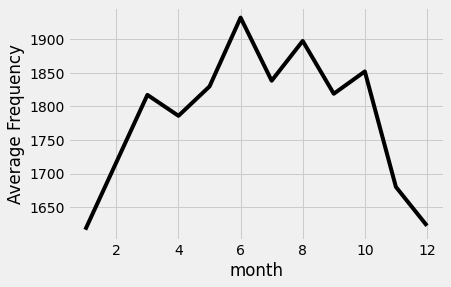

In [14]:
night['month'] = night['date_time'].dt.month
by_month = night.groupby('month').mean()
by_month['traffic_volume'].plot(kind='line', ylabel='Average Frequency', colormap='bone')

Traffic looks less heavy during the cold months and more intense during warm months except July and September. July could be due to the closure.

### Day of Week Analysis

<AxesSubplot:xlabel='dayofweek', ylabel='Average Frequency'>

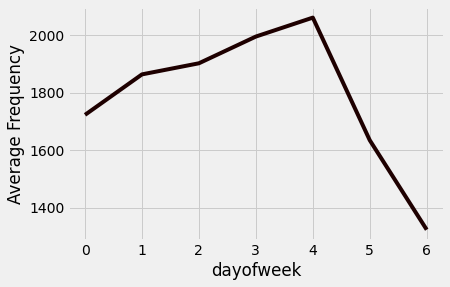

In [15]:
night['dayofweek'] = night['date_time'].dt.dayofweek
by_dayofweek = night.groupby('dayofweek').mean()
by_dayofweek['traffic_volume'].plot(kind='line',ylabel='Average Frequency', colormap='pink')

Looking at the traffic per day (Monday = 0 and Sunday = 6), we can see that the weekend traffic drops significantly.

### Hour Analysis

Text(0.5, 1.0, 'Traffic Volume By Hour: Weekend')

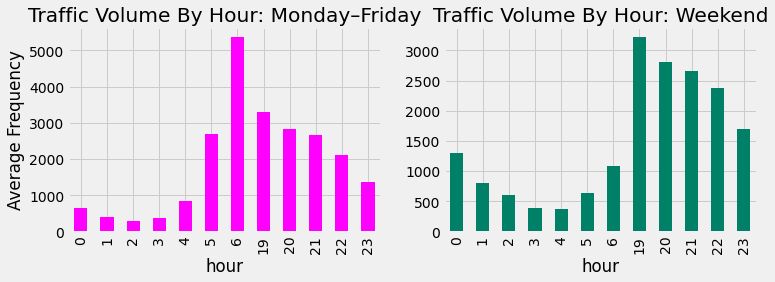

In [16]:
night['hour'] = night['date_time'].dt.hour
bussiness_days = night.copy()[night['dayofweek'] <= 4] # 4 == Friday
weekend = night.copy()[night['dayofweek'] >= 5] # 5 = Saturday
by_hour_business = bussiness_days.groupby('hour').mean()
by_hour_weekend = weekend.groupby('hour').mean()


plt.figure(figsize=(11,3.5))

plt.subplot(1, 2, 1)
by_hour_business['traffic_volume'].plot(kind='bar',ylabel='Average Frequency',colormap='spring')
plt.title('Traffic Volume By Hour: Monday–Friday')

plt.subplot(1, 2, 2)
by_hour_weekend['traffic_volume'].plot(kind='bar',colormap='summer')
plt.title('Traffic Volume By Hour: Weekend')

Traffic volume at night is much higher on the weekends. Early morning traffic (7 AM) is pretty high during the week which coincides with rush hour.

## Analyzing Weather Indicators

Another possible indicator of heavy traffic is weather. Let's start looking at correlations with traffic_volume.

In [17]:
day.corr()['traffic_volume']

temp              0.128317
rain_1h           0.003697
snow_1h           0.001265
clouds_all       -0.032932
traffic_volume    1.000000
month            -0.022337
year             -0.003557
dayofweek        -0.416453
hour              0.172704
Name: traffic_volume, dtype: float64

Strongest correlation weather-related correlation seems to be temperature. It is still fairly weak which we can see in a plot below:

(230.0, 320.0)

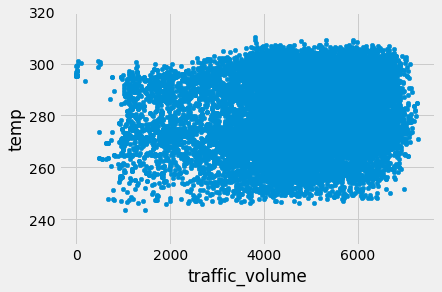

In [18]:
day.plot('traffic_volume', 'temp', kind='scatter')
plt.ylim(230, 320) # two wrong 0K temperatures mess up the y-axis

(230.0, 320.0)

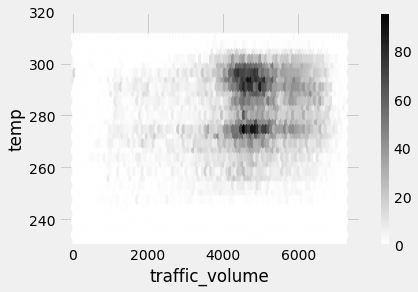

In [19]:
day.plot('traffic_volume', 'temp', kind='hexbin', gridsize=100, colormap='gist_yarg')
plt.ylim(230, 320)

### Weather Types

Let's now look at type of weather to see if it has a significant effect.

<AxesSubplot:ylabel='weather_main'>

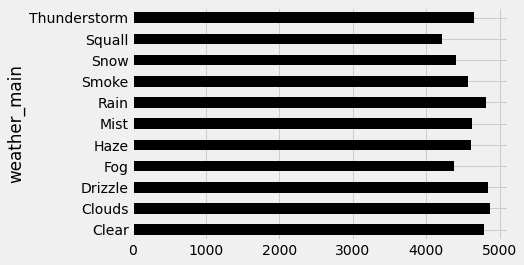

In [20]:
by_weather_main = day.groupby('weather_main').mean()
by_weather_main['traffic_volume'].plot(kind='barh', colormap='gist_gray')

<AxesSubplot:ylabel='weather_description'>

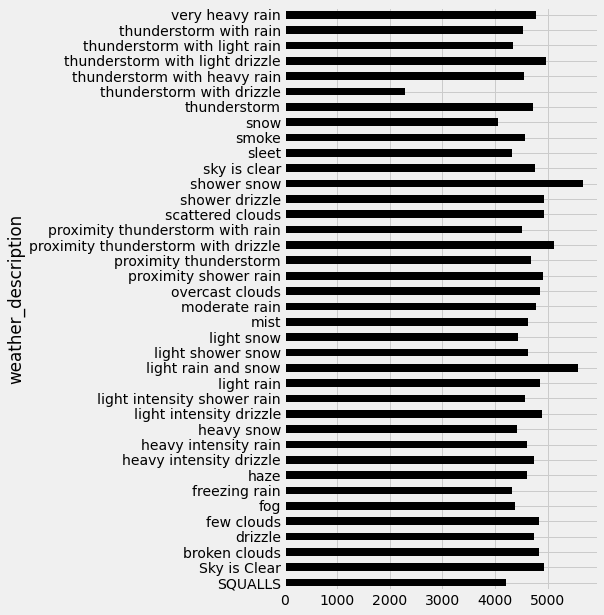

In [21]:
by_weather_description = day.groupby('weather_description').mean()
by_weather_description['traffic_volume'].plot(kind='barh', figsize=(5,10), colormap='gray')

From above, we can see that traffic is interestingly higher during the following conditions:
- Shower snow
- Light rain and snow
- Proximity thunderstorm with drizzle

## Holiday Analysis

Finally, let's look at holidays to see the influence on traffic.

<AxesSubplot:xlabel='holiday', ylabel='Average Freqency'>

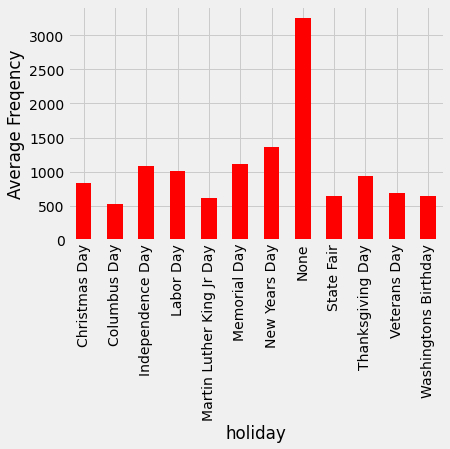

In [30]:
by_holiday = traffic.groupby('holiday').mean()
by_holiday['traffic_volume'].plot(kind='bar', ylabel='Average Freqency', colormap='autumn')

We can see reduced traffic on holidays by a factor of about 3-7 depending on the holiday.

## Conclusions

In conclusion regarding time:

- The traffic is usually heavier during warm months (March–October) compared to cold months (November–February).
- The traffic is usually heavier on business days compared to weekends.
- On business days, the rush hours are around 8 (AM) and 16 (5 PM).

In conclusion regarding weather, bad weather conditions tend to have slightly higher traffic which may indicate that weather is not as an important factor in driving. After all, if you have to be out, you will be out regardless unless the weather is as severe.